# 04 – Data Analysis and Visualization

This notebook performs the main **data analysis and visualization** for the
project using the integrated dataset:

- `data/processed/coffee_integrated.csv`

It focuses on the research questions defined in the project plan:

1. **Which coffee products generate the highest sales volume and/or revenue across locations?**
2. **How do customer preferences (e.g., drink type, size, add-ons) vary by time of day and store/location?**
3. **Can integrated sales and shop-level data reveal which operational factors (e.g., location, product mix) are associated with higher daily sales?**

The notebook:

- Loads the integrated dataset.
- Computes key metrics such as revenue.
- Produces tables and visualizations:
  - Top products by quantity and revenue
  - Time-of-day patterns (by hour and Time_of_Day)
  - Store/location performance
- Saves selected figures under `figures/` for inclusion in the final report.

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Paths
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
FIGURES_DIR = PROJECT_ROOT / "figures"

INTEGRATED_PATH = PROCESSED_DIR / "coffee_integrated.csv"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, DATA_DIR, PROCESSED_DIR, FIGURES_DIR

(PosixPath('/Users/ujjwal/Downloads/IS-477-Project-Ujjwal'),
 PosixPath('/Users/ujjwal/Downloads/IS-477-Project-Ujjwal/data'),
 PosixPath('/Users/ujjwal/Downloads/IS-477-Project-Ujjwal/data/processed'),
 PosixPath('/Users/ujjwal/Downloads/IS-477-Project-Ujjwal/figures'))

## 1. Load integrated dataset

We load the integrated dataset produced by `scripts/integrate_data.py` /
`02_integration.ipynb`, which combines:

- Transaction-level sales data (quantities, prices, products, store info).
- Hour-of-day shop profile (time-of-day labels, average money, etc.).

In [2]:
integrated = pd.read_csv(INTEGRATED_PATH)

print("Integrated shape:", integrated.shape)
integrated.head()

Integrated shape: (149116, 20)


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,transaction_time_parsed,hour_of_day,transaction_date_parsed,weekday,money,Time_of_Day,Weekday,Month_name,revenue
0,1,1/1/23,7:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2025-12-01 07:06:11,7,2023-01-01,Sunday,32.341136,Morning,Sun,May,6.0
1,2,1/1/23,7:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2025-12-01 07:08:56,7,2023-01-01,Sunday,32.341136,Morning,Sun,May,6.2
2,3,1/1/23,7:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,2025-12-01 07:14:04,7,2023-01-01,Sunday,32.341136,Morning,Sun,May,9.0
3,4,1/1/23,7:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2025-12-01 07:20:24,7,2023-01-01,Sunday,32.341136,Morning,Sun,May,2.0
4,5,1/1/23,7:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2025-12-01 07:22:41,7,2023-01-01,Sunday,32.341136,Morning,Sun,May,6.2


In [3]:
# Ensure a revenue column exists: revenue = transaction_qty * unit_price
if "revenue" not in integrated.columns and {"transaction_qty", "unit_price"}.issubset(integrated.columns):
    integrated["revenue"] = integrated["transaction_qty"] * integrated["unit_price"]

integrated[["transaction_id", "transaction_qty", "unit_price", "revenue"]].head()

,transaction_id,transaction_qty,unit_price,revenue
0,1,2,3.0,6.0
1,2,2,3.1,6.2
2,3,2,4.5,9.0
3,4,1,2.0,2.0
4,5,2,3.1,6.2


## 2. Basic overview of integrated data

We start with a few quick checks:

- Column names and dtypes
- Missing values
- Basic numeric summary for key metrics like `transaction_qty`, `unit_price`, and `revenue`.

In [4]:
print("=== Integrated info ===")
print(integrated.info())

=== Integrated info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           149116 non-null  int64  
 1   transaction_date         149116 non-null  object 
 2   transaction_time         149116 non-null  object 
 3   transaction_qty          149116 non-null  int64  
 4   store_id                 149116 non-null  int64  
 5   store_location           149116 non-null  object 
 6   product_id               149116 non-null  int64  
 7   unit_price               149116 non-null  float64
 8   product_category         149116 non-null  object 
 9   product_type             149116 non-null  object 
 10  product_detail           149116 non-null  object 
 11  transaction_time_parsed  149116 non-null  object 
 12  hour_of_day              149116 non-null  int64  
 13  transaction_date_parsed  149116 non

In [5]:
print("=== Missing values ===")
integrated.isna().sum()

=== Missing values ===


transaction_id             0
transaction_date           0
transaction_time           0
transaction_qty            0
store_id                   0
store_location             0
product_id                 0
unit_price                 0
product_category           0
product_type               0
product_detail             0
transaction_time_parsed    0
hour_of_day                0
transaction_date_parsed    0
weekday                    0
money                      0
Time_of_Day                0
Weekday                    0
Month_name                 0
revenue                    0
dtype: int64

In [6]:
print("=== Numeric summary (revenue-related) ===")
cols = [c for c in ["transaction_qty", "unit_price", "revenue"] if c in integrated.columns]
integrated[cols].describe()

=== Numeric summary (revenue-related) ===


,transaction_qty,unit_price,revenue
count,149116.000000,149116.000000,149116.000000
mean,1.438276,3.382219,4.686367
std,0.542509,2.658723,4.227099
min,1.000000,0.800000,0.800000
25%,1.000000,2.500000,3.000000
50%,1.000000,3.000000,3.750000
75%,2.000000,3.750000,6.000000
max,8.000000,45.000000,360.000000


## 3. Top products by quantity and revenue

This section addresses part of Research Question 1:

> Which coffee products generate the highest sales volume and/or revenue across locations?

Depending on the dataset, we may have product-level fields such as:

- `product_type`
- `product_category`
- `product_detail`
- `product_id`

We will compute:

- Total quantity sold by product
- Total revenue by product
- Top 10 products by each metric

In [7]:
# Choose a product dimension to analyze (adjust if needed depending on your columns)
product_col = None
for candidate in ["product_type", "product_category", "product_detail", "product_id"]:
    if candidate in integrated.columns:
        product_col = candidate
        break

product_col

'product_type'

In [8]:
if product_col is not None:
    product_summary = (
        integrated
        .groupby(product_col, as_index=False)
        .agg(
            total_qty=("transaction_qty", "sum"),
            total_revenue=("revenue", "sum")
        )
        .sort_values("total_revenue", ascending=False)
    )

    print(f"Top 10 products by total revenue (grouped by {product_col}):")
    top_products = product_summary.head(10)
    top_products
else:
    print("No suitable product column found for aggregation.")

Top 10 products by total revenue (grouped by product_type):


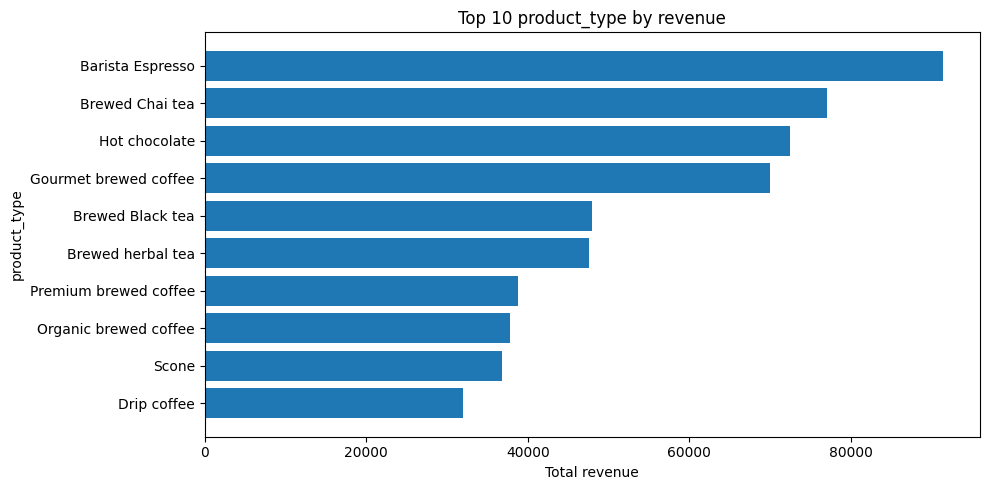

In [9]:
if product_col is not None:
    plt.figure(figsize=(10, 5))
    top_products_sorted = top_products.sort_values("total_revenue", ascending=True)
    plt.barh(top_products_sorted[product_col], top_products_sorted["total_revenue"])
    plt.xlabel("Total revenue")
    plt.ylabel(product_col)
    plt.title(f"Top 10 {product_col} by revenue")
    plt.tight_layout()

    fig_path = FIGURES_DIR / "top_products_by_revenue.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()

    fig_path

## 4. Time-of-day patterns

This section contributes to Research Question 2:

> How do customer preferences (e.g., drink type, size, add-ons) vary by time of day and store/location?

We examine:

- Revenue by `hour_of_day`
- Revenue by `Time_of_Day` (e.g., Morning, Afternoon, Evening)
- Number of transactions by hour and by time-of-day category

In [10]:
if "hour_of_day" in integrated.columns:
    rev_by_hour = (
        integrated
        .groupby("hour_of_day", as_index=False)
        .agg(
            total_revenue=("revenue", "sum"),
            num_transactions=("transaction_id", "count")
        )
        .sort_values("hour_of_day")
    )

    rev_by_hour
else:
    print("hour_of_day column not found in integrated dataset.")

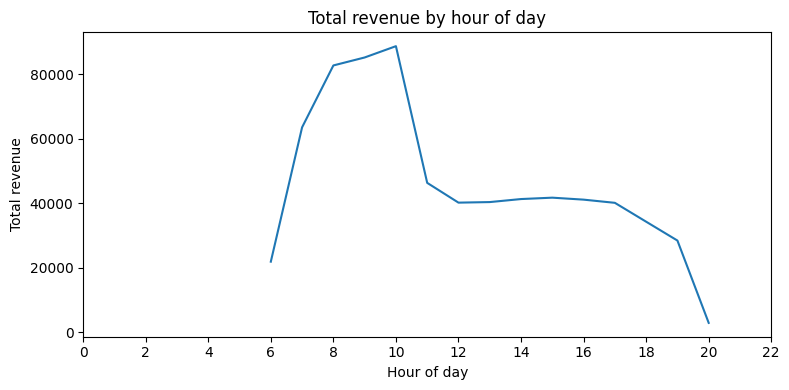

In [11]:
if "hour_of_day" in integrated.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(rev_by_hour["hour_of_day"], rev_by_hour["total_revenue"])
    plt.xlabel("Hour of day")
    plt.ylabel("Total revenue")
    plt.title("Total revenue by hour of day")
    plt.xticks(range(0, 24, 2))
    plt.tight_layout()

    fig_path = FIGURES_DIR / "revenue_by_hour_of_day.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()

    fig_path

In [12]:
if "Time_of_Day" in integrated.columns:
    rev_by_tod = (
        integrated
        .groupby("Time_of_Day", as_index=False)
        .agg(
            total_revenue=("revenue", "sum"),
            num_transactions=("transaction_id", "count")
        )
        .sort_values("total_revenue", ascending=False)
    )

    rev_by_tod
else:
    print("Time_of_Day column not found in integrated dataset.")

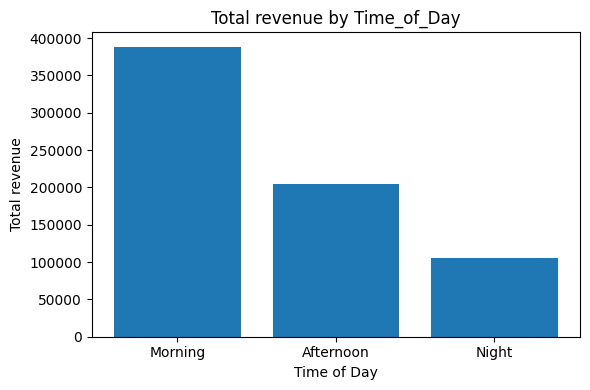

In [13]:
if "Time_of_Day" in integrated.columns:
    plt.figure(figsize=(6, 4))
    plt.bar(rev_by_tod["Time_of_Day"], rev_by_tod["total_revenue"])
    plt.xlabel("Time of Day")
    plt.ylabel("Total revenue")
    plt.title("Total revenue by Time_of_Day")
    plt.tight_layout()

    fig_path = FIGURES_DIR / "revenue_by_time_of_day.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()

    fig_path

## 5. Store/location performance

This section supports Research Question 3:

> Can integrated sales and shop-level data reveal which operational factors (e.g., location, product mix) are associated with higher daily sales?

As a first step, we:

- Compute total revenue and number of transactions per `store_location`.
- Visualize the top-performing stores.

In [14]:
if "store_location" in integrated.columns:
    rev_by_store = (
        integrated
        .groupby("store_location", as_index=False)
        .agg(
            total_revenue=("revenue", "sum"),
            num_transactions=("transaction_id", "count")
        )
        .sort_values("total_revenue", ascending=False)
    )

    rev_by_store.head(10)
else:
    print("store_location column not found in integrated dataset.")

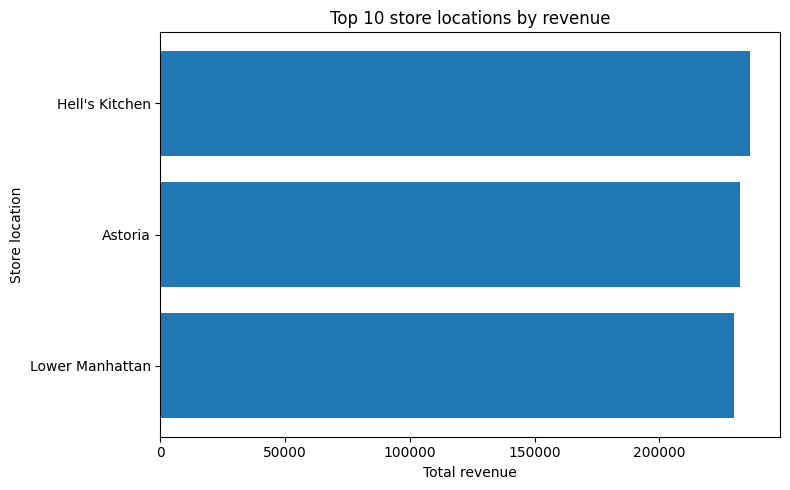

In [15]:
if "store_location" in integrated.columns:
    top_stores = rev_by_store.head(10)
    top_stores_sorted = top_stores.sort_values("total_revenue", ascending=True)

    plt.figure(figsize=(8, 5))
    plt.barh(top_stores_sorted["store_location"], top_stores_sorted["total_revenue"])
    plt.xlabel("Total revenue")
    plt.ylabel("Store location")
    plt.title("Top 10 store locations by revenue")
    plt.tight_layout()

    fig_path = FIGURES_DIR / "top_stores_by_revenue.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()

    fig_path

## 6. Summary of analysis and visualizations

Key outputs from this notebook (saved in `figures/`):

- `top_products_by_revenue.png` – Top 10 products by total revenue.
- `revenue_by_hour_of_day.png` – Total revenue by hour of day.
- `revenue_by_time_of_day.png` – Total revenue by time-of-day category.
- `top_stores_by_revenue.png` – Top 10 store locations by total revenue.

These figures and the corresponding tables provide the main evidence used
to answer the research questions in the final report.

They are referenced in the **Findings** section of `README.md` and can be
regenerated by running this notebook or by using the automated script
`scripts/make_figures.py`.